# Trying to align signals using dynamic time warping

In [11]:
import os
from pathlib import Path
import sys
import pandas as pd
from matplotlib import pyplot as plt
from dtw import dtw


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Recreate `dtw` example

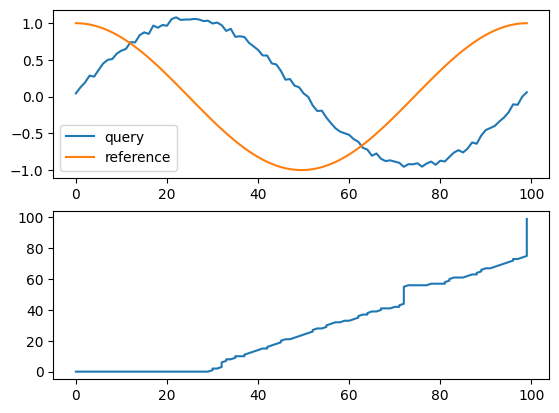

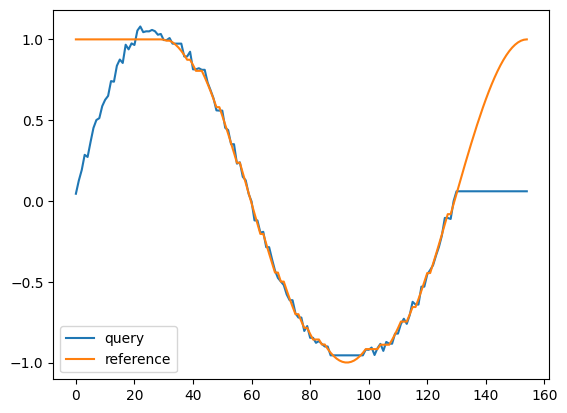

In [ ]:
import numpy as np
from dtw import *
import matplotlib.pyplot as plt

idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0
reference = np.cos(idx)
alignment = dtw(query,reference)

# plot query and reference
plt.figure()
plt.subplot(2,1,1)
plt.plot(query, label='query')
plt.plot(reference, label='reference')
plt.legend()
plt.subplot(2,1,2)
plt.plot(alignment.index1, alignment.index2)	

# align both signals
plt.figure()
plt.plot(query[alignment.index1], label='query')
plt.plot(reference[alignment.index2], label='reference')
plt.legend()

## Load some real data

Time length for 03_02_25: 2065390
Time length for 05_02_25: 2065466
Time length for 17_02_25: 2065436


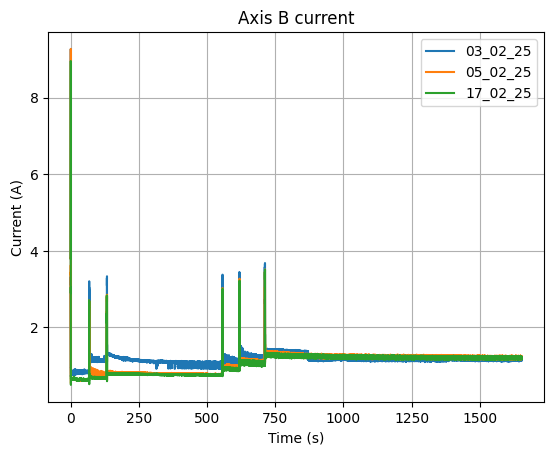

In [12]:
dataPath: Path = "../../data/normalized-2025_05_08/"

machineName = 'Mecatis'

path = os.path.join(current_folder, dataPath)

dates = ['03_02_25', '05_02_25', '17_02_25']

signalName = 'stSigAxCurrentS'

times: list[pd.Series] = []
signals: list[pd.Series] = []

for date in dates:
    sampleName = f'{machineName}_{date}.parquet'
    samplePath = os.path.join(path, sampleName)
    sample = pd.read_parquet(samplePath)

    times.append(sample['timeSeconds'])
    signals.append(sample[signalName]*1000)

# check time lengths
for i, time in enumerate(times):
    print(f'Time length for {dates[i]}: {len(time)}')

# plot signals
plt.figure()
# plot all signals in one plot
for i, signal in enumerate(signals):
    plt.plot(times[i], signal, label=dates[i])
plt.legend()

plt.title('Axis B current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()

## Cut only part of the signals

In [22]:
from utils.getRmse import getRmse

# function to print errors between ref and queries
def printErrors(ref, queries):
    print('Errors:')
    for i in range(len(queries)):
        error = getRmse(ref,queries[i])
        print(round(error, 4))
    

frequency: 1250.0 Hz
nbPoints: 3750
startIndex: 888750, endIndex: 892500
Errors:
0.3155
0.2452


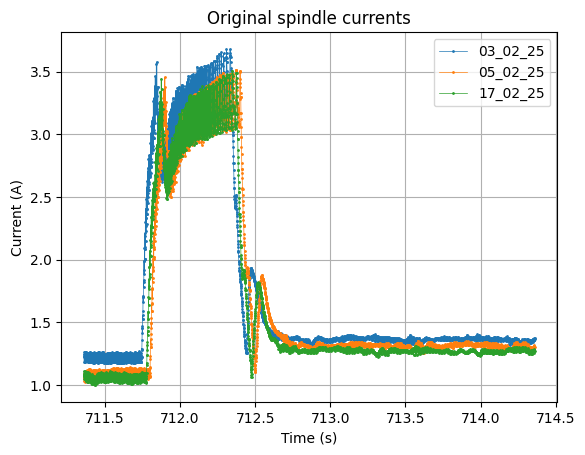

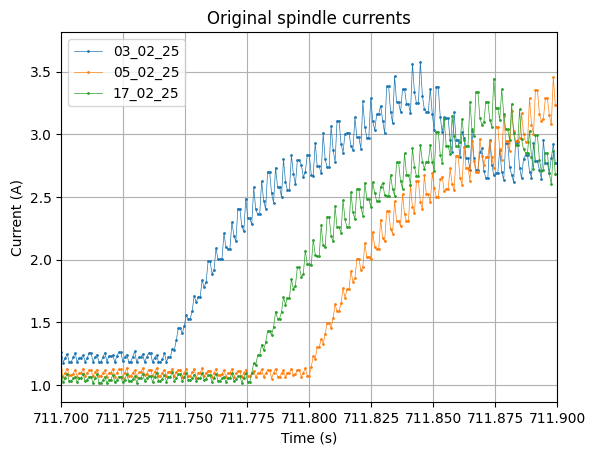

In [40]:
frequency = 1/(times[0][1] - times[0][0]) # seconds

print(f'frequency: {frequency} Hz')

startTime = 711 # seconds
endTime = 714 # seconds

startIndex = int(startTime * frequency)
endIndex = int(endTime * frequency)

nbPoints = endIndex - startIndex
print(f'nbPoints: {nbPoints}')

print(f'startIndex: {startIndex}, endIndex: {endIndex}')

cutSignals = [signal[startIndex:endIndex] for signal in signals]
cutTimes = [time[startIndex:endIndex] for time in times]


# compute errors
printErrors(cutSignals[0], cutSignals[1:])


# plot signals
plt.figure()
# plot all signals in one plot
for i in range(len(cutSignals)):
    plt.plot(cutTimes[i], cutSignals[i],"o-", markersize=1, lw = 0.5, label=dates[i],)
plt.legend()
plt.title('Original spindle currents')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()


# zoom in on the signals
plt.figure()
# plot all signals in one plot
for i in range(len(cutSignals)):
    plt.plot(cutTimes[i], cutSignals[i],"o-", markersize=1, lw = 0.5, label=dates[i],)
plt.legend()
plt.title('Original spindle currents')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.xlim(711.7, 711.9)
plt.grid()

## Use DTW to align 2 signals

Text(0, 0.5, 'Current (A)')

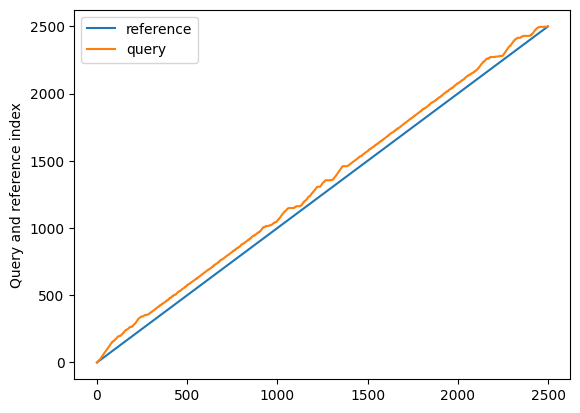

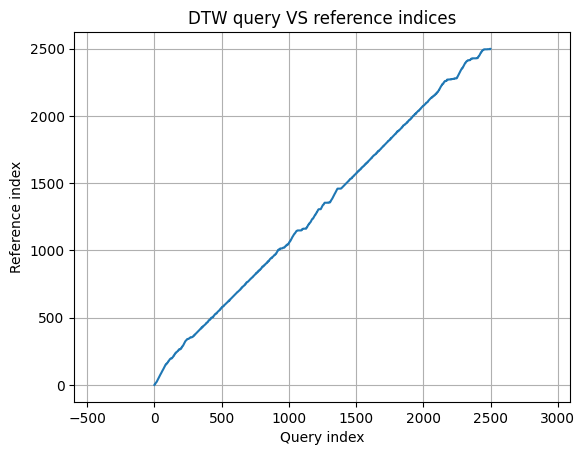

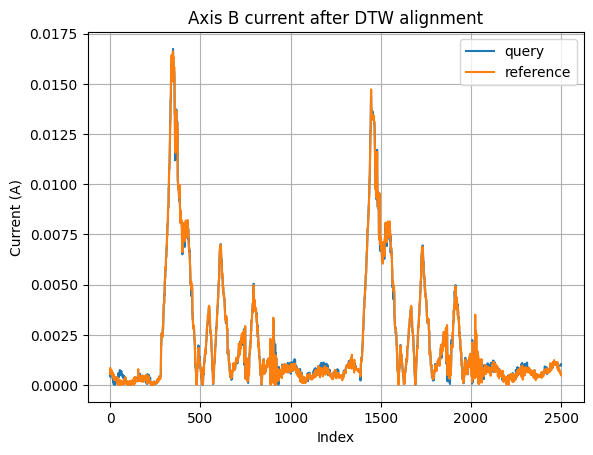

In [53]:
reference = cutSignals[0]
query = cutSignals[1]
alignment = dtw(reference, query, step_pattern="asymmetric")

# plot indices
plt.figure()
plt.plot(alignment.index1)
plt.plot(alignment.index2)
plt.ylabel('Query and reference index')
plt.legend(['reference', 'query'])

# plot alignment   
plt.figure()
plt.plot(alignment.index1, alignment.index2)
plt.title('DTW query VS reference indices')
plt.xlabel('Query index')
plt.ylabel('Reference index')
plt.grid()
plt.axis('equal')

# align both signals
plt.figure()
plt.plot(query[alignment.index2], label='query')
plt.plot(reference, label='reference')
plt.legend()
plt.grid()
plt.title('Axis B current after DTW alignment')
plt.xlabel('Index')
plt.ylabel('Current (A)')


## Align multiple signals on a reference

Using the dtw library on all points of a signal (around 2e6 points) becomes really slow!

Running the code below on the whole signals even makes the kernel crash??
- 1/10 of signal length still crashes (206539 points)
- 1/100 of signal length (20653 points) runs in 22 s

Errors:
0.0557
0.076


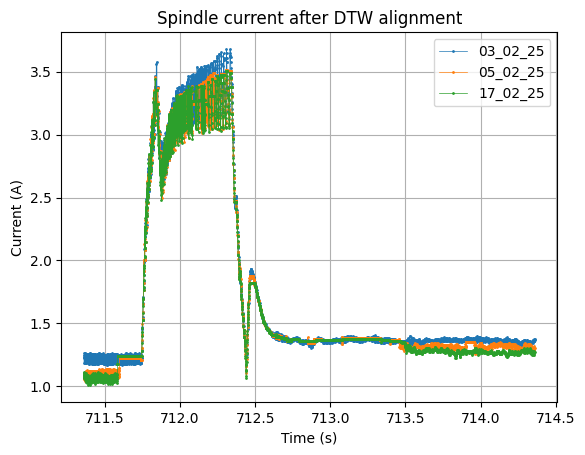

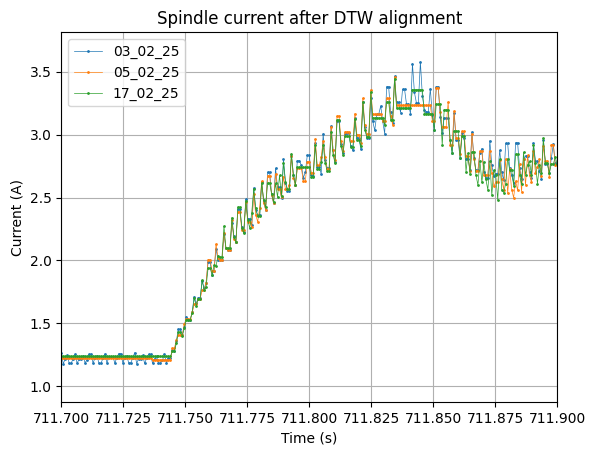

In [41]:
reference = cutSignals[0]
queries = cutSignals[1:]

dtwSignals = [reference.reset_index(drop=True)]  # start with the reference signal
for query in queries:
    alignment = dtw(reference, query, step_pattern="asymmetric")
    dtwSignals.append(query.iloc[alignment.index2].reset_index(drop=True))

# compute errors
printErrors(dtwSignals[0], dtwSignals[1:])

# plot aligned signals
plt.figure()
# plot all signals in one plot
for i in range(len(dtwSignals)):
    plt.plot(cutTimes[i], dtwSignals[i], "o-", markersize=1, lw = 0.5, label=dates[i])
plt.legend()
plt.title('Spindle current after DTW alignment')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()

# zoom in on the signals
plt.figure()
# plot all signals in one plot
for i in range(len(dtwSignals)):
    plt.plot(cutTimes[0], dtwSignals[i],"o-", markersize=1, lw = 0.5, label=dates[i],)
plt.legend()
plt.title('Spindle current after DTW alignment')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.xlim(711.7, 711.9)
plt.grid()


## Try aligning signals in x and y instead

### Y offset correction

Y offset for 05_02_25: -0.08051946329349728
Y offset for 17_02_25: -0.11551404970060093
Errors:
0.305
0.2163


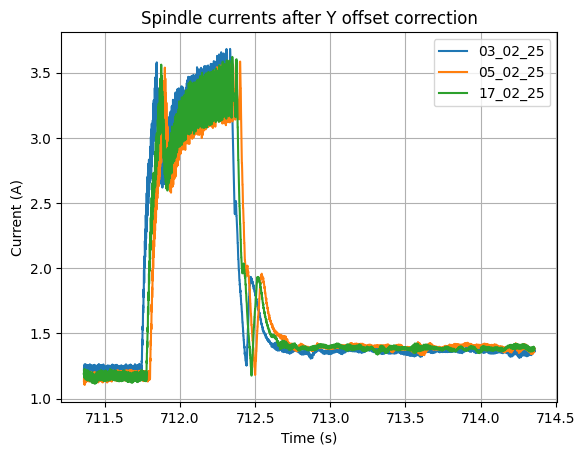

In [6]:
from utils.findOffsetY import findOffsetY

reference = cutSignals[0]
queries = cutSignals[1:]

refTime = cutTimes[0]
sigTimes = cutTimes[1:]

queriesCorrectedY = []

for i in range(len(queries)):
    yOffset = findOffsetY(queries[i], reference)[0]
    print(f'Y offset for {dates[i+1]}: {yOffset}')
    queriesCorrectedY.append(queries[i] - yOffset)

# compute errors
printErrors(reference, queriesCorrectedY)


# plot aligned signals with corrected Y offset
plt.figure()
plt.plot(refTime, reference, label=dates[0])
for i in range(len(queriesCorrectedY)):
    plt.plot(sigTimes[i], queriesCorrectedY[i], label=dates[i+1])
plt.legend()
plt.title('Spindle currents after Y offset correction')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()

### X offset correction

X offset for 05_02_25: -0.0448 seconds
X offset for 17_02_25: -0.0208 seconds


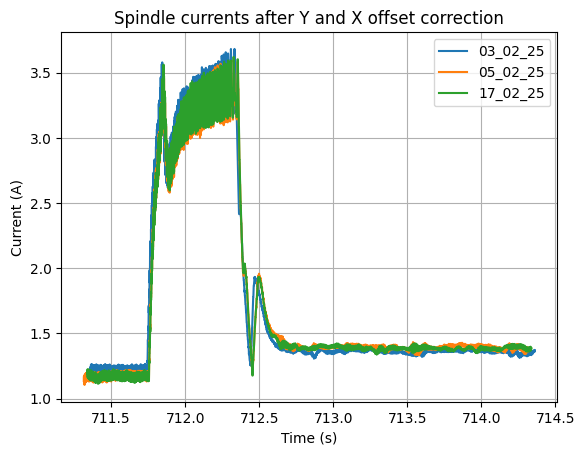

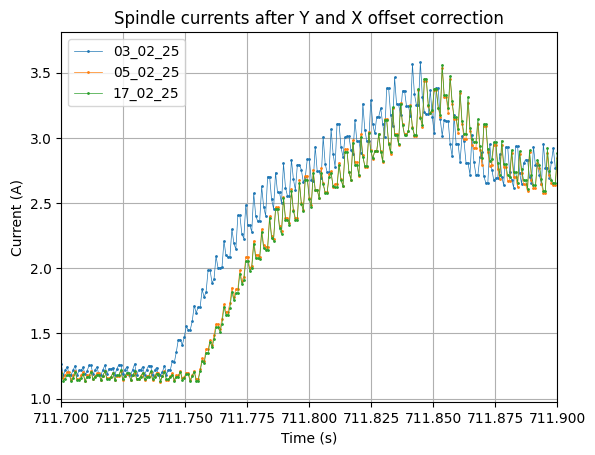

In [42]:
from utils.findOffsetX import findOffsetX

offsets = []
offsetTimes = []
for i in range(len(queriesCorrectedY)):
    xOffset = findOffsetX(queriesCorrectedY[i], reference)
    offsets.append(xOffset)
    timeOffset = xOffset / frequency

    print(f'X offset for {dates[i+1]}: {timeOffset} seconds')
    offsetTimes.append(sigTimes[i] + timeOffset)

# plot aligned signals with corrected Y offset and X offset
plt.figure()
plt.plot(refTime, reference, label=dates[0])
for i in range(len(queriesCorrectedY)):
    plt.plot(offsetTimes[i], queriesCorrectedY[i], label=dates[i+1])
plt.legend()
plt.title('Spindle currents after Y and X offset correction')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()


# zoom in on the signals
plt.figure()
# plot all signals in one plot
plt.plot(refTime, reference, "o-", markersize=1, lw = 0.5, label=dates[0])
for i in range(len(queriesCorrectedY)):
    plt.plot(offsetTimes[i], queriesCorrectedY[i],"o-", markersize=1, lw = 0.5,  label=dates[i+1])
plt.legend()
plt.title('Spindle currents after Y and X offset correction')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.xlim(711.7, 711.9)
plt.grid()


In [8]:
# computing errors for signals with time offset corrected

# from utils.findCommonSection import findCommonSection

from utils.findCommonSection import findCommonSection


reference = cutSignals[0]
signals = queriesCorrectedY.copy()

for i in range(len(signals)):
    commonSection = findCommonSection(signals[i], reference, offsets[i])

    error = getRmse(commonSection["signal"], commonSection["reference"])

    print(f'Error for {dates[i+1]}: {error:.4f}')


Error for 05_02_25: 0.1263
Error for 17_02_25: 0.1259


## Combine y offset and DTW

Errors:
0.0282
0.0267


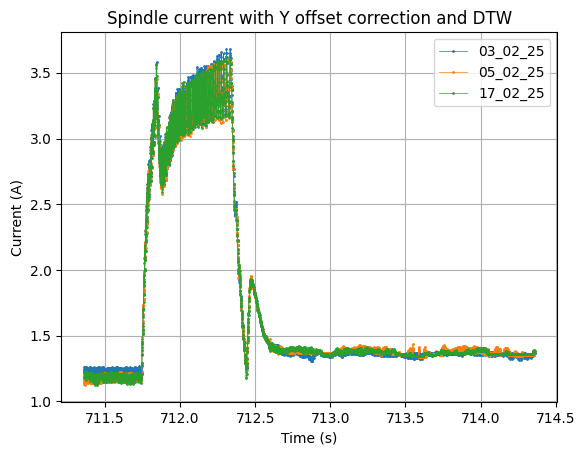

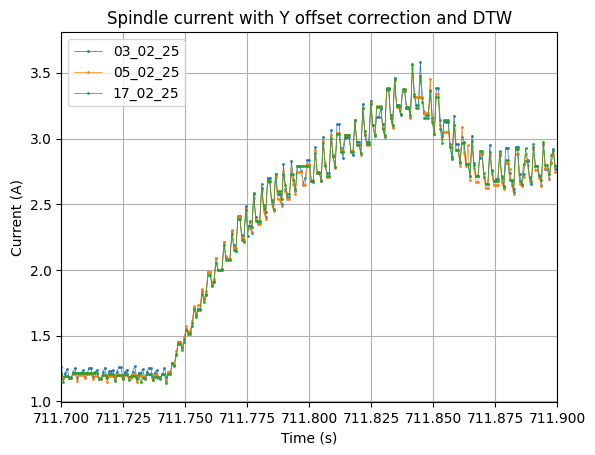

In [39]:
reference = cutSignals[0]
queries = queriesCorrectedY

dtwSignals = [reference.reset_index(drop=True)]  # start with the reference signal
for query in queries:
    alignment = dtw(reference, query, step_pattern="asymmetric")
    dtwSignals.append(query.iloc[alignment.index2].reset_index(drop=True))

# compute errors
printErrors(dtwSignals[0], dtwSignals[1:])

# plot aligned signals
plt.figure()
# plot all signals in one plot
for i in range(len(dtwSignals)):
    plt.plot(cutTimes[i], dtwSignals[i], "o-", markersize=1, lw = 0.5, label=dates[i])
plt.legend()
plt.title('Spindle current with Y offset correction and DTW')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()

# zoom in on the signals
plt.figure()
# plot all signals in one plot
for i in range(len(dtwSignals)):
    plt.plot(cutTimes[0], dtwSignals[i],"o-", markersize=1, lw = 0.5, label=dates[i],)
plt.legend()
plt.title('Spindle current with Y offset correction and DTW')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.xlim(711.7, 711.9)
plt.grid()